In [1]:
# Set up the workspace
using SumOfSquares, JuMP, PolyJuMP, DynamicPolynomials, MultivariatePolynomials, RecursiveArrayTools
using Mosek#, CSDP#, SCS
using Plots
gr()

include("../src/NormalSoS.jl")
using NormalSoS

INFO: Recompiling stale cache file /cluster/home/rdb13/.julia/lib/v0.6/SumOfSquares.ji for module SumOfSquares.
INFO: Recompiling stale cache file /cluster/home/rdb13/.julia/lib/v0.6/DynamicPolynomials.ji for module DynamicPolynomials.
INFO: Recompiling stale cache file /cluster/home/rdb13/.julia/lib/v0.6/RecursiveArrayTools.ji for module RecursiveArrayTools.
INFO: Recompiling stale cache file /cluster/home/rdb13/.julia/lib/v0.6/Plots.ji for module Plots.


In [2]:
# Function to construct a real, negative-definite, non-normal matrix A, of size n×n
function randsys(n)
    
    # S = -rand(Float64,n-1) + vcat(zeros(Float64,n-2),[0.5])im
    # push!(S,S[n-1]')
    S = -rand(Float64,n); # Choose the eigenvalues
    
    S = diagm(S);
    Q = eye(n);
    for ii=1:n # Choose the random normalised eigenvectors
        v = randn(Float64,n);
        v = v./norm(v);
        Q[:,ii] = v;
    end
    A = Q*S*inv(Q);    # Constructs real matrix A with eigenvalues S, eigenvectors v
    println("Computed matrix A")
    
    return A
    
end

randsys (generic function with 1 method)

# Linear Examples

As a first test case we will examine the linear example of Zhou _et al._ (2012). For a linear system the dynamics is expressed in terms of a matrix $A$, and the properties of the decomposition are determined by some well known properties of this matrix.
\begin{equation}
    \dot{x} = f(x) = Ax.
\end{equation}
If $A$ is a normal matrix, then an orthogonal decomposition should be achieveable via a symmetric-antisymmetric decomposition. In this case the quasi-potential is given by:
\begin{equation}
    V(x) = -\frac{1}{2}((A+A^*)x,x),
\end{equation}
where the brackets denote an inner product.

If $A$ is not normal, then the quasipotential is given by the slightly more complicated expression:
\begin{equation}
    V(x) = -\frac{1}{2}\left( \left( \int_0^\infty \exp(At) \exp(A^*t)\,\text{d}t\right)^{-1}x, x \right).
\end{equation}
Such a quasipotential will not satisfy a normal decomposition. A useful comparison can therefore be made between this analytical expression for the quasipotential and that resulting from the SoS method for non-normal linear systems.

In [3]:
# A 2D normal example - WORKS
n = 2;    @polyvar x[1:n]
A = [-5.0 0.2;
     0.2 -1.0];
F1(X::Vector) = A*X;
f1 = F1(x);
U1 = NormalSoS.normdecomp(f1,x, MosekSolver(),0);

(λ,u) = eig(A);
(~,v) = eig(A');
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j]);
end
V1 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x));

Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^2, x1x2, x2^2, x1, x2, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 98              
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

In [27]:
@show(U1);    @show(V1);    @show(λ);

U1 = 2.499999995607779x1^2 - 0.19999999229723395x1x2 + 0.49999999447044546x2^2 + 2.69039587883021
V1 = 2.5x1^2 - 0.2x1x2 + 0.5x2^2
λ = [-5.00998, -0.990025]


In [ ]:
# A 3D normal example - WORKS
n = 3;    @polyvar x[1:n]
A = [-5.0 0.0 0.2;
     0.0 -1.5 0.0;
     0.2 0.0 -1.0];
F2(X::Vector) = A*X;
f2 = F2(x);
U2 = NormalSoS.normdecomp(f2,x, MosekSolver(),0);

(λ,u) = eig(A);
(~,v) = eig(A');
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j]);
end
V2 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x));

In [30]:
@show(U2);    @show(V2);    @show(λ);

U2 = 2.4999998459624364x1^2 - 0.1999996920830655x1x3 + 0.7499999729568393x2^2 + 0.4999997328638468x3^2 + 1.799493653406083
V2 = 2.4999999999999996x1^2 - 0.1999999999999999x1x3 + 0.75x2^2 + 0.5x3^2
λ = [-5.00998, -1.5, -0.990025]


In [ ]:
# A 2D non-normal example - WORKS
n = 2;    @polyvar x[1:n]
A = [-5.0 3.8;
     0.2 -1.0];
F3(X::Vector) = A*X;
f3 = F3(x);
U3 = NormalSoS.normdecomp(f3,x, MosekSolver(),0);

(λ,u) = eig(A);
(~,v) = eig(A');
P = diagm(λ);
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j]);
end
V3 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x));

In [8]:
@show(U3);    @show(V3);    @show(λ);
# NormalSoS.checknorm(f3,U3,x)

LoadError: [91mUndefVarError: U3 not defined[39m

In [28]:
# A 3D non-normal example - WORKS and agrees with quasipotential
n = 3;    @polyvar x[1:n]
A = [-5.0 0.0 0.2;
     0.0 -1.5 3.0;
     0.5 -5.0 -1.0];
F4(X::Vector) = A*X;
f4 = F4(x);
U4 = NormalSoS.normdecomp(f4,x, MosekSolver(),2);

(λ,u) = eig(A);
(~,v) = eig(A');
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j]);
end
V4 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x));

Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^2, x1x2, x1x3, x2^2, x2x3, x3^2, x1, x2, x3, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 279             
  Cones                  : 0               
  Scalar variables       : 13              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   :

In [29]:
@show(U4);    # @show(V4);    
@show(λ);

U4 = 2.5038941181966954x1^2 - 0.13613247303694745x1x2 - 0.17953171984273597x1x3 + 0.774517237967514x2^2 + 0.01896960956424136x2x3 + 0.4715885741757095x3^2 + 1.8063541979012472
λ = Complex{Float64}[-5.01207+0.0im, -1.24396+3.85783im, -1.24396-3.85783im]


In [30]:
Ag = convert(Array,VectorOfArray(coefficients.(-differentiate(U4,x))))'

3×3 Array{Float64,2}:
 -5.00779    0.136132    0.179532 
  0.136132  -1.54903    -0.0189696
  0.179532  -0.0189696  -0.943177 

In [31]:
Ac = convert(Array,VectorOfArray(coefficients.(f4 + differentiate(U4,x))))'

3×3 Array{Float64,2}:
  0.00778824  -0.136132    0.0204683
 -0.136132     0.0490345   3.01897  
  0.320468    -4.98103    -0.0568229

In [4]:
# A 5D non-normal example with oscillatory dynamics - Orthogonal but does not match quasipotential
n = 5;    @polyvar x[1:n]
A = [-5.0 3.0 0.2 0.0 1.5;
     0.0 -1.5 0.0 0.0 0.5;
     -0.2 0.0 -1.0 0.0 1.0;
     0.0 1.2 0.0 -0.5 0.0;
     1.5 0.0 -3.0 0.0 -1.0];
F5(X::Vector) = A*X;
f5 = F5(x);
U5 = NormalSoS.normdecomp(f5,x, MosekSolver(),0);

(λ,u) = eig(A);
(~,v) = eig(A');
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j]);
end
V5 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x));

Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^2, x1x2, x1x3, x1x4, x1x5, x2^2, x2x3, x2x4, x2x5, x3^2, x3x4, x3x5, x4^2, x4x5, x5^2, x1, x2, x3, x4, x5, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0               
  Scalar variables       : 26              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Object

U5 = 2.0494185880556817x1^2 - 1.8125099996917033x1x2 - 0.7676737776541611x1x3 - 0.16803931591424467x1x4 - 1.1971199599911695x1x5 + 1.2180778436122575x2^2 + 0.057751565533307334x2x3 - 0.14689491711058086x2x4 + 0.1518972469851035x2x5 + 0.6496139544802867x3^2 - 0.04676495649634916x3x4 + 0.3083944765843497x3x5 + 0.16907830114542752x4^2 + 0.05220978579905337x4x5 + 0.4138089010726228x5^2 + 1.5672295443771338


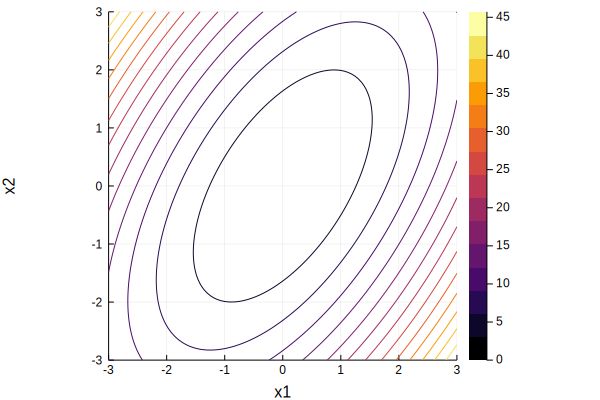

In [5]:
@show(U5);    #@show(V5);    @show(λ);
plt5 = NormalSoS.plotlandscape(f5,U5,x,([-3 3],[-3 3]), false);    plot(plt5)

In [16]:
Ag = convert(Array,VectorOfArray(coefficients.(-differentiate(U5,x))))'
eig(Ag*(A-Ag))[1]
# det(A-Ag)

5-element Array{Complex{Float64},1}:
 1.01376e-5+3.46033im 
 1.01376e-5-3.46033im 
 9.36674e-7+0.822512im
 9.36674e-7-0.822512im
 2.86423e-7+0.0im     

In [5]:
Ac = convert(Array,VectorOfArray(coefficients.(f5 + differentiate(U5,x))))'

5×5 Array{Float64,2}:
 -0.901163  1.18749    -0.567674   -0.168039    0.30288  
 -1.81251   0.936156    0.0577516  -0.146895    0.651897 
 -0.967674  0.0577516   0.299228   -0.046765    1.30839  
 -0.168039  1.05311    -0.046765   -0.161843    0.0522098
  0.30288   0.151897   -2.69161     0.0522098  -0.172382 

In [23]:
# Display simulations of the 5 state system with damped oscillatory dynamics
using DifferentialEquations

u0 = [-2.5;2.5;1.0;1.0;10.0];
tspan = (0.0,10.0);
f(u,p,t) = F5(u);
prob = ODEProblem(f,u0,tspan);
sol = DifferentialEquations.solve(prob);

plot(plt5)
plot!(sol[1,:],sol[2,:], color=:black, legend=false)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 -3 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 x1 
 
 
 x2 
 
 
<polyline clip-path="url(#clip4102)" style="stroke:#470b69; stroke-width:1; stroke-opacity:1; fill:none" points="
 142.324,360.065 140.193,356.624 140.149,356.548 138.282,353.03 136.676,349.678 136.601,349.512 135.158,345.995 133.865,342.477 133.158,340.332 132.733,338.959 
 131.758,335.441 130.902,331.924 130.161,328.406 129.64,325.529 129.531,324.888 129.018,321.37 128.598,317.853 128.267,314.335 128.02,310.817 127.853,307.3 
 127.763,303.782 127.746,300.264 127.799,296.746 127.919,293.229 128.104,289.711 128.349,286.193 128.654,282.676 129.015,279.158 129.43,275.64 129.64,274.067 
 129.905,272.122 130.438,268.605 131.019,265.087 131.648,261.569 132.322,258.052 133.04,254.534 133.158,253.991 133.818,251.016 134.64,247.498 135.502,243.981 
 136.402,240.463 136.676,239.444 137.357,236.945 138.356,233.427 139.389,229.91 140.193,227.261 140.462,226.392 141.59,222.874 142.748,219.357 143.711,216.512 
 143.942,215.839 145.193,212.321 146.47,208.803 147.229,206.767 147.789,205.286 149.155,201.768 150.546,198.25 150.747,197.755 151.993,194.733 153.468,191.215 
 154.264,189.353 154.984,187.697 156.543,184.179 157.782,181.424 158.13,180.662 159.771,177.144 161.3,173.905 161.433,173.626 163.155,170.108 164.817,166.745 
 164.895,166.591 166.696,163.073 168.335,159.9 168.516,159.555 170.396,156.038 171.853,153.335 172.299,152.52 174.255,149.002 175.371,147.016 176.245,145.484 
 178.276,141.967 178.888,140.919 180.355,138.449 182.406,135.021 182.461,134.931 184.632,131.414 185.924,129.336 186.834,127.896 189.077,124.378 189.441,123.813 
 191.378,120.86 192.959,118.465 193.713,117.343 196.095,113.825 196.477,113.267 198.536,110.307 199.995,108.225 201.017,106.789 203.512,103.308 203.539,103.272 
 206.133,99.7541 207.03,98.545 208.773,96.2363 210.548,93.8999 211.461,92.7186 214.066,89.37 214.199,89.2009 217.01,85.6832 217.583,84.9701 219.879,82.1654 
 221.101,80.6823 222.807,78.6477 224.619,76.5008 225.797,75.13 228.136,72.4236 228.851,71.6123 231.654,68.4488 231.974,68.0946 235.17,64.5768 235.172,64.5749 
 238.452,61.0591 238.69,60.8055 241.813,57.5414 242.207,57.1312 245.258,54.0237 245.725,53.5504 248.792,50.506 249.243,50.0615 252.422,46.9882 252.76,46.663 
 256.153,43.4705 256.278,43.3534 259.796,40.1351 260,39.9528 263.314,37.0071 263.972,36.4351 266.831,33.9656 268.074,32.9174 270.349,31.009 272.315,29.3996 
 273.867,28.1359 276.705,25.8819 277.384,25.345 280.902,22.6407 281.273,22.3642 284.42,20.0292 286.058,18.8465 287.938,17.4974 291.045,15.3287 291.455,15.044 
 294.973,12.6863 296.322,11.811 
 "/>
<polyline clip-path="url(#clip4102)" style="stroke:#63146e; stroke-width:1; stroke-opacity:1; fill:none" points="
 262.803,11.811 259.796,14.4323 258.788,15.3287 256.278,17.5703 254.877,18.8465 252.76,20.7835 251.066,22.3642 249.243,24.0729 247.348,25.8819 245.725,27.4397 
 243.72,29.3996 242.207,30.8849 240.175,32.9174 238.69,34.4098 236.709,36.4351 235.172,38.0154 233.319,39.9528 231.654,41.7031 230.001,43.4705 228.136,45.474 
 226.751,46.9882 224.619,49.3294 223.565,50.506 221.101,53.2705 220.441,54.0237 217.583,57.2987 217.375,57.5414 214.374,61.0591 214.066,61.4224 211.433,64.5768 
 210.548,65.6427 208.544,68.0946 207.03,69.9561 205.704,71.6123 203.512,74.364 202.911,75.13 200.169,78.6477 199.995,78.8727 197.486,82.1654 196.477,83.4973 
 194.845,85.6832 192.959,88.2234 192.244,89.2009 189.687,92.7186 189.441,93.06 187.187,96.2363 185.924,98.0253 184.721,99.7541 182.406,103.1 182.289,103.272 
 179.915,106.789 178.888,108.32 177.574,110.307 175.371,113.66 175.264,113.825 173.01,117.343 171.853,119.16 170.786,120.86 168.594,124.378 168.335,124.798 
 166.453,127.896 164.817,130.606 164.337,131.414 162.266,134.931 161.3,136.588 160.229,138.449 158.222,141.967 157.782,1

In [32]:
# Perform many optimisations in a loop to test timing and accuracy
Nvec = [2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 9 10 10 10 10 10];
Tvec = zeros(Float64.(Nvec));
Evec = zeros(Tvec);

for ii=1:length(Nvec)
    n = Nvec[ii];
    @polyvar x[1:n]
    A = randsys(n)
    F(X::Vector) = A*X;
    f = F(x);
    Tvec[ii] = @elapsed U = NormalSoS.normdecomp(f,x, MosekSolver(),5);
    Evec[ii] = NormalSoS.checknorm(f,U,x);
    if isnan(Evec[ii]);    Tvec[ii] = NaN;    end;
end

Computed matrix A
Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^2, x1x2, x2^2, x1, x2, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 98              
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CON

Computed matrix A
Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^2, x1x2, x2^2, x1, x2, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 98              
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CON

MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(101) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(102) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(103) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 104             
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number        

Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 104             
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 102
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 9                 conic                  : 7               
Optimizer  - Semi-definite variables: 3                 scalarized             : 132             
Factor     - setup time             : 0.00  

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 98              
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 98              
  Cones                  : 0  

  Dual.    obj: -9.2253018741e+03   nrm: 2e+06    Viol.  con: 0e+00    var: 2e-04    barvar: 2e-03  
Computed matrix A


Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^2, x1x2, x2^2, x1, x2, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 98              
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(101) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(102) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(103) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 104             
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number        


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 4.8003527721e-06    nrm: 8e+02    Viol.  con: 1e-06    var: 0e+00    barvar: 0e+00  
  Dual.    obj: 8.0519533014e-06    nrm: 1e+03    Viol.  con: 0e+00    var: 6e-10    barvar: 1e-09  


MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(101) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(102) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(103) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 104             
  Cones                  : 0               
  Scalar variables       : 8               
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number        

6   1.4e-05  1.4e-05  5.7e-04  2.75e-01   -8.320293658e-02  -8.271541073e-02  1.4e-05  0.03  
7   2.1e-06  2.1e-06  1.5e-04  2.96e-01   -7.497917426e-02  -7.479410009e-02  2.1e-06  0.04  
8   3.8e-07  3.8e-07  7.4e-05  6.50e-01   -7.305840263e-02  -7.303594784e-02  3.8e-07  0.04  
9   4.1e-08  4.1e-08  2.4e-05  9.40e-01   -7.273336758e-02  -7.273090630e-02  4.1e-08  0.05  
10  1.4e-09  1.3e-09  4.5e-06  9.84e-01   -7.267639781e-02  -7.267633826e-02  1.3e-09  0.05  
Optimizer terminated. Time: 0.05    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -7.2676397807e-02   nrm: 7e+00    Viol.  con: 2e-08    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -7.2676338258e-02   nrm: 8e+01    Viol.  con: 0e+00    var: 1e-08    barvar: 2e-08  
status = :Optimal
bnd = x1^2 + x2^2 + x3^2
getvalue(ϵ) = [1.66487e-8, 4.77461e-9, 0.0726764]
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(284) of matrix 

3   4.9e-05  1.0e-01  2.6e-05  2.48e-01   -7.854815132e+04  -7.489201380e+04  4.9e-05  0.02  
4   1.0e-05  2.1e-02  8.4e-06  3.17e+00   -3.652545575e+03  -2.115373215e+03  1.0e-05  0.02  
5   4.7e-07  9.6e-04  2.3e-06  1.24e+00   -1.600088587e+02  -1.178582608e+02  4.7e-07  0.02  
6   6.2e-08  1.3e-04  1.0e-06  1.17e+00   -2.042768719e+01  -1.670858138e+01  6.2e-08  0.03  
7   6.1e-09  1.0e-05  5.1e-07  1.13e+00   -1.856864761e+00  -1.760222968e+00  5.0e-09  0.04  
8   1.6e-09  1.1e-06  1.2e-07  1.07e+00   -1.811929324e-01  -1.615189056e-01  5.4e-10  0.05  
9   1.6e-09  1.1e-06  1.2e-07  1.10e+00   -1.811929324e-01  -1.615189056e-01  5.4e-10  0.06  
Optimizer terminated. Time: 0.07    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -1.8119293243e-01   nrm: 4e+03    Viol.  con: 2e-01    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -1.6151890559e-01   nrm: 6e+03    Viol.  con: 0e+00    var: 2e-06    barvar: 3e-0

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 288             
  Cones                  : 0               
  Scalar variables       : 12              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 286
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 13                conic                  : 11              
Optimizer  - Semi-definite variables: 3                 scalarized             : 426             
Factor     - setup time             : 0.00              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor :

1   1.2e-01  2.5e+02  4.3e-02  -9.98e-01  -2.142147126e+03  -3.519102187e+02  1.2e-01  0.01  
2   9.3e-04  1.9e+00  3.9e-05  -9.87e-01  -1.729000502e+05  -2.967098486e+04  9.3e-04  0.01  
3   1.1e-04  2.3e-01  2.5e-05  4.23e-01   -3.147575863e+04  -2.602185878e+04  1.1e-04  0.02  
4   1.2e-05  2.4e-02  1.5e-05  2.06e+00   -9.118781442e+02  -7.657809667e+02  1.2e-05  0.02  
5   1.3e-06  2.6e-03  7.9e-06  1.34e+00   -1.188234503e+02  -1.123849642e+02  1.3e-06  0.03  
6   1.8e-07  3.7e-04  3.8e-06  1.24e+00   -1.594947397e+01  -1.537731366e+01  1.8e-07  0.03  
7   1.6e-08  3.2e-05  7.3e-07  1.12e+00   -1.554639461e+00  -1.441556450e+00  1.5e-08  0.04  
8   9.4e-09  4.8e-06  2.4e-07  1.16e+00   -2.052288794e-01  -1.799783161e-01  2.4e-09  0.04  
9   6.0e-09  2.1e-08  5.0e-09  9.35e-01   7.692554086e-05   1.168088842e-03   3.4e-11  0.05  
10  1.4e-09  2.5e-09  2.4e-10  -7.63e-01  7.900044035e-03   1.480225328e-02   4.0e-12  0.05  
11  7.2e-10  1.2e-09  1.2e-10  -5.40e-01  4.296369060e-02   

MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(284) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(285) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(286) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(287) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 288             
  Cones                  : 0               
  Scalar variables       : 12              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries           

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 279             
  Cones                  : 0               
  Scalar variables       : 13              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 279             
  Cones                  : 0  

Optimizer terminated. Time: 0.05    


Interior-point solution summary
  Problem status  : UNKNOWN
  Solution status : UNKNOWN
  Primal.  obj: -7.2300882946e+04   nrm: 1e+06    Viol.  con: 7e+04    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -6.4827283123e+04   nrm: 3e+06    Viol.  con: 0e+00    var: 2e-03    barvar: 5e-03  
Computed matrix A
Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^2, x1x2, x1x3, x2^2, x2x3, x3^2, x1, x2, x3, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 279             
  Cones                  : 0               
  Scalar variables       : 13              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time  

MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(284) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(285) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(286) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(287) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 288             
  Cones                  : 0               
  Scalar variables       : 12              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries           

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 288             
  Cones                  : 0               
  Scalar variables       : 12              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 286
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 13                conic                  : 11              
Optimizer  - Semi-definite variables: 3                 scalarized             : 426             
Factor     - setup time             : 0.00              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor :

8   4.7e-07  4.7e-07  6.3e-05  7.35e-01   -1.444595371e-01  -1.444084819e-01  4.7e-07  0.04  
9   8.0e-08  8.0e-08  5.1e-05  9.03e-01   -1.441797091e-01  -1.441780537e-01  7.9e-08  0.04  
10  8.4e-10  7.8e-10  7.8e-10  9.87e-01   -1.441175266e-01  -1.441174848e-01  8.5e-10  0.05  
Optimizer terminated. Time: 0.05    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -1.4411752663e-01   nrm: 6e+00    Viol.  con: 2e-08    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -1.4411748484e-01   nrm: 8e+01    Viol.  con: 0e+00    var: 8e-09    barvar: 8e-09  
status = :Optimal
bnd = x1^2 + x2^2 + x3^2
getvalue(ϵ) = [0.144117, 6.12269e-8, 1.76375e-8]
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(284) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(285) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(286) of matr

MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(285) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(286) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(287) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 288             
  Cones                  : 0               
  Scalar variables       : 12              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number        

MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(284) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(285) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(286) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(287) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 288             
  Cones                  : 0               
  Scalar variables       : 12              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries           

1   1.4e-01  4.7e+03  5.4e-02  -1.00e+00  -2.524649567e+04  -1.143987175e+03  1.4e-01  0.01  
2   3.4e-03  1.1e+02  2.0e-04  -9.99e-01  -1.239437346e+06  -6.326056454e+04  3.3e-03  0.01  
3   6.2e-05  2.0e+00  7.0e-07  -9.70e-01  -3.388040737e+07  -1.856637308e+06  6.2e-05  0.02  
4   2.8e-06  9.2e-02  1.7e-07  2.98e-01   -3.420836061e+06  -2.254808448e+06  2.8e-06  0.02  
5   2.5e-07  8.3e-03  2.4e-07  2.02e+00   -1.562192542e+05  -1.517605823e+05  2.5e-07  0.03  
6   6.6e-08  2.2e-03  1.0e-07  1.32e+00   -3.287966443e+04  -3.115866839e+04  6.6e-08  0.03  
7   2.7e-09  6.5e-05  2.0e-08  1.24e+00   -8.817719664e+02  -8.428904590e+02  2.0e-09  0.04  
8   7.3e-10  3.2e-07  1.6e-09  1.01e+00   -4.285074758e+00  -4.139127784e+00  9.3e-12  0.05  
9   7.3e-10  3.2e-07  1.6e-09  1.25e+00   -4.285074758e+00  -4.139127784e+00  9.3e-12  0.06  
Optimizer terminated. Time: 0.07    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal. 

3   8.9e-04  2.2e-01  5.3e-04  4.85e-01   -4.319686285e+03  -3.648048891e+03  8.7e-04  0.02  
4   1.2e-04  3.1e-02  2.8e-04  2.54e+00   -1.879982043e+02  -1.416421057e+02  1.2e-04  0.02  
5   8.7e-06  2.2e-03  1.1e-04  1.47e+00   -1.121509389e+01  -9.695581865e+00  8.6e-06  0.03  
6   1.6e-08  3.9e-06  6.5e-06  1.06e+00   -2.198927831e-02  -2.068685305e-02  1.5e-08  0.03  
7   6.6e-10  5.5e-09  1.2e-07  1.01e+00   -2.308935050e-05  -1.517216449e-05  3.8e-11  0.04  
Optimizer terminated. Time: 0.04    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -2.3089350500e-05   nrm: 3e+02    Viol.  con: 2e-05    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -1.5172164581e-05   nrm: 5e+02    Viol.  con: 0e+00    var: 4e-09    barvar: 9e-09  
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(284) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(285) of matr

2   3.0e-02  3.0e-02  2.1e-01  1.15e+00   -1.634775300e-01  -1.778952616e-01  3.0e-02  0.06  
3   3.9e-03  3.9e-03  5.4e-02  1.02e+00   -5.329221269e-02  -5.269984058e-02  3.9e-03  0.08  
4   8.4e-04  8.4e-04  2.5e-02  6.34e-01   -2.035154997e-02  -2.038256895e-02  8.4e-04  0.11  
5   1.5e-04  1.5e-04  8.0e-03  7.62e-01   -7.984753866e-03  -7.881253008e-03  1.5e-04  0.13  
6   3.1e-05  3.1e-05  2.7e-03  6.62e-01   -3.810277687e-03  -3.742916403e-03  3.1e-05  0.15  
7   5.7e-06  5.7e-06  7.8e-04  5.62e-01   -2.118644114e-03  -2.082997577e-03  5.7e-06  0.17  
8   1.2e-06  1.2e-06  2.6e-04  5.95e-01   -1.483335420e-03  -1.466418405e-03  1.2e-06  0.19  
9   2.1e-07  2.0e-07  7.8e-05  4.80e-01   -1.182405444e-03  -1.176657741e-03  2.0e-07  0.21  
10  3.2e-08  2.7e-08  2.6e-05  8.25e-01   -1.098460443e-03  -1.097498614e-03  2.8e-08  0.23  
11  4.3e-09  1.4e-09  5.5e-10  9.01e-01   -1.082426024e-03  -1.082399856e-03  6.5e-10  0.25  
Optimizer terminated. Time: 0.25    


Interior-point soluti

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 647             
  Cones                  : 0               
  Scalar variables       : 17              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 645
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 18                conic                  : 16              
Optimizer  - Semi-definite variables: 3                 scalarized             : 1065            
Factor     - setup time             : 0.02              dense det. time        : 0.00            
Factor     - ML order time          : 0.01              GP order time          : 0.00            
Factor     - nonzeros before factor : 1.91e+0

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 634             
  Cones                  : 0               
  Scalar variables       : 19              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 634             
  Cones                  : 0  

MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(642) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(643) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(644) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(645) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(646) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 647             
  Cones                  : 0               
  Scalar variables       : 17              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries             

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 647             
  Cones                  : 0               
  Scalar variables       : 17              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 647             
  Cones                  : 0  

MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(642) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(643) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(644) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(645) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(646) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 647             
  Cones                  : 0               
  Scalar variables       : 17              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries             

2   4.6e-03  9.4e+00  3.0e-04  -1.01e+00  -2.711071493e+05  -3.284076498e+04  4.6e-03  0.07  
3   6.1e-04  1.2e+00  4.2e-05  -6.93e-01  -2.779952788e+05  -6.122089472e+04  6.1e-04  0.09  
4   8.7e-05  1.8e-01  3.3e-05  1.16e+00   -3.719399081e+04  -3.015020709e+04  8.7e-05  0.12  
5   9.1e-06  1.8e-02  1.2e-05  1.91e+00   -2.929699371e+03  -2.392850914e+03  9.0e-06  0.15  
6   6.5e-07  1.3e-03  6.0e-06  1.14e+00   -2.065472637e+02  -1.949565963e+02  6.5e-07  0.18  
7   6.8e-08  1.4e-04  1.8e-06  1.03e+00   -1.759784213e+01  -1.620420379e+01  6.6e-08  0.21  
8   1.6e-08  1.8e-05  6.6e-07  1.14e+00   -2.354629896e+00  -2.167718957e+00  8.7e-09  0.23  
9   1.2e-08  1.0e-05  5.1e-07  1.09e+00   -1.320481093e+00  -1.219650868e+00  5.0e-09  0.26  
10  1.2e-08  1.0e-05  5.1e-07  1.15e+00   -1.320481093e+00  -1.219650868e+00  5.0e-09  0.30  
Optimizer terminated. Time: 0.31    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal. 

2   2.2e-02  2.2e-02  1.2e-01  1.25e+00   -9.497995918e-01  -9.427298864e-01  2.2e-02  0.06  
3   4.5e-03  4.5e-03  5.1e-02  1.03e+00   -8.143988539e-01  -8.124197489e-01  4.5e-03  0.09  
4   5.9e-04  5.9e-04  1.5e-02  7.93e-01   -7.704976925e-01  -7.697497705e-01  5.9e-04  0.10  
5   4.4e-05  4.4e-05  3.6e-03  8.80e-01   -7.633157245e-01  -7.632330607e-01  4.4e-05  0.12  
6   5.9e-07  5.9e-07  7.1e-04  9.52e-01   -7.625756429e-01  -7.625759262e-01  5.9e-07  0.14  
7   3.8e-09  3.8e-09  5.8e-05  9.97e-01   -7.625661280e-01  -7.625661300e-01  3.8e-09  0.17  
Optimizer terminated. Time: 0.17    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -7.6256612801e-01   nrm: 1e+00    Viol.  con: 6e-09    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -7.6256613004e-01   nrm: 8e+00    Viol.  con: 0e+00    var: 6e-09    barvar: 6e-09  
status = :Optimal
bnd = x1^2 + x2^2 + x3^2 + x4^2
getvalue(ϵ) = [-2.54667e-9, 0.0900578, 0

2   5.9e-03  1.5e+00  6.0e-04  -9.48e-01  -3.098512081e+04  -7.139806057e+03  5.8e-03  0.07  
3   1.0e-03  2.5e-01  7.5e-04  9.32e-01   -3.672831799e+03  -3.243111187e+03  9.9e-04  0.09  
4   1.5e-04  3.7e-02  3.2e-04  2.49e+00   -1.788971138e+02  -1.276635982e+02  1.5e-04  0.12  
5   1.8e-05  4.6e-03  1.4e-04  1.37e+00   -1.843653260e+01  -1.421175619e+01  1.8e-05  0.14  
6   9.3e-07  2.4e-04  4.1e-05  1.13e+00   -9.900135227e-01  -8.682659261e-01  9.2e-07  0.16  
7   8.6e-09  2.2e-06  4.0e-06  1.02e+00   -8.924197302e-03  -7.781081757e-03  8.5e-09  0.19  
8   4.5e-09  2.0e-08  1.3e-07  8.72e-01   5.158870316e-05   1.501585385e-04   1.9e-10  0.20  
9   8.3e-10  4.5e-11  3.8e-11  -7.63e-01  9.052830432e-03   1.438481431e-02   2.0e-12  0.23  
10  1.1e-10  7.0e-12  8.2e-13  -9.84e-01  1.194065296e-01   1.838905874e-01   1.5e-13  0.25  
11  1.1e-10  7.0e-12  8.2e-13  -4.70e-01  1.194065296e-01   1.838905874e-01   1.5e-13  0.29  
Optimizer terminated. Time: 0.31    


Interior-point soluti

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 634             
  Cones                  : 0               
  Scalar variables       : 19              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 630
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 20                conic                  : 16              
Optimizer  - Semi-definite variables: 2                 scalarized             : 1050            
Factor     - setup time             : 0.03              dense det. time        : 0.00            
Factor     - ML order time          : 0.01              GP order time          : 0.00            
Factor     - nonzeros before factor : 1.90e+0

2   1.8e-02  1.8e-02  1.0e-01  1.49e+00   -1.365691951e+00  -1.355862456e+00  1.8e-02  0.06  
3   1.8e-03  1.8e-03  3.4e-02  9.90e-01   -1.214792954e+00  -1.214254845e+00  1.8e-03  0.08  
4   5.5e-04  5.5e-04  1.8e-02  8.94e-01   -1.199370675e+00  -1.199181478e+00  5.5e-04  0.10  
5   1.7e-05  1.7e-05  3.3e-03  9.70e-01   -1.191494362e+00  -1.191489229e+00  1.7e-05  0.12  
6   1.2e-06  1.2e-06  8.7e-04  9.98e-01   -1.191304225e+00  -1.191303940e+00  1.2e-06  0.15  
7   7.5e-09  7.5e-09  1.0e-04  9.98e-01   -1.191292589e+00  -1.191292594e+00  7.5e-09  0.17  
Optimizer terminated. Time: 0.17    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -1.1912925893e+00   nrm: 1e+00    Viol.  con: 1e-08    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -1.1912925935e+00   nrm: 3e+00    Viol.  con: 0e+00    var: 1e-08    barvar: 1e-08  
status = :Optimal
bnd = x1^2 + x2^2 + x3^2 + x4^2
getvalue(ϵ) = [0.257457, 0.307313, 0.289

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 647             
  Cones                  : 0               
  Scalar variables       : 17              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 647             
  Cones                  : 0  

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0               
  Scalar variables       : 26              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1242
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 27                conic                  : 22              
Optimizer  - Semi-definite variables: 2                 scalarized             : 2232            
Factor     - setup time             : 0.11              dense det. time        : 0.00            
Factor     - ML order time          : 0.05              GP order time          : 0.00            
Factor     - nonzeros before factor : 7.47e+

MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1259) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1260) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1261) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1262) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1263) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1264) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Li

MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1259) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1260) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1261) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1262) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1263) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1264) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Li

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1263
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 24                conic                  : 22              
Optimizer  - Semi-definite variables: 3                 scalarized             : 2253            
Factor     - setup time             : 0.11              dense det. time        : 0.00            
Factor     - ML order time          : 0.05              GP order time          : 0.00            
Factor     - nonzeros before factor 

MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1259) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1260) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1261) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1262) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1263) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1264) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Li

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0               
  Scalar variables       : 26              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0  

MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1259) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1260) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1261) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1262) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1263) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1264) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Li

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones               

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1263
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 24                conic                  : 22              
Optimizer  - Semi-definite variables: 3                 scalarized             : 2253            
Factor     - setup time             : 0.11              dense det. time        : 0.00            
Factor     - ML order time          : 0.05              GP order time          : 0.00            
Factor     - nonzeros before factor 

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1263
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 24                conic                  : 22              
Optimizer  - Semi-definite variables: 3                 scalarized             : 2253            
Factor     - setup time             : 0.11              dense det. time        : 0.00            
Factor     - ML order time          : 0.05              GP order time          : 0.00            
Factor     - nonzeros before factor 

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0               
  Scalar variables       : 26              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0  

MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1259) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1260) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1261) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1262) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1263) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1264) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Li

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1263
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 24                conic                  : 22              
Optimizer  - Semi-definite variables: 3                 scalarized             : 2253            
Factor     - setup time             : 0.11              dense det. time        : 0.00            
Factor     - ML order time          : 0.05              GP order time          : 0.00            
Factor     - nonzeros before factor 

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1263
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 24                conic                  : 22              
Optimizer  - Semi-definite variables: 3                 scalarized             : 2253            
Factor     - setup time             : 0.11              dense det. time        : 0.00            
Factor     - ML order time          : 0.05              GP order time          : 0.00            
Factor     - nonzeros before factor 

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0               
  Scalar variables       : 26              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0  

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1263
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 24                conic                  : 22              
Optimizer  - Semi-definite variables: 3                 scalarized             : 2253            
Factor     - setup time             : 0.11              dense det. time        : 0.00            
Factor     - ML order time          : 0.05              GP order time          : 0.00            
Factor     - nonzeros before factor 

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0               
  Scalar variables       : 26              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1247            
  Cones                  : 0  

MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1259) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1260) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1261) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1262) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1263) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1264) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Li

MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1259) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1260) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1261) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1262) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1263) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(1264) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Li

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1265            
  Cones                  : 0               
  Scalar variables       : 23              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1263
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 24                conic                  : 22              
Optimizer  - Semi-definite variables: 3                 scalarized             : 2253            
Factor     - setup time             : 0.13              dense det. time        : 0.00            
Factor     - ML order time          : 0.06              GP order time          : 0.00            
Factor     - nonzeros before factor 

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2218            
  Cones                  : 0               
  Scalar variables       : 34              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2218            
  Cones                  : 0  

MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2235) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2236) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2237) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2238) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2239) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2240) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2241) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3   

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2218            
  Cones                  : 0               
  Scalar variables       : 34              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2218            
  Cones                  : 0  

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2218            
  Cones                  : 0               
  Scalar variables       : 34              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2218            
  Cones                  : 0  

MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2235) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2236) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2237) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2238) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2239) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2240) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2241) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3   

MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2235) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2236) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2237) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2238) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2239) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2240) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2241) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3   

MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2235) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2236) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2237) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2238) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2239) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2240) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2241) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3   

MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2235) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2236) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2237) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2238) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2239) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2240) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2241) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3   

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 2240
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 31                conic                  : 29              
Optimizer  - Semi-definite variables: 3                 scalarized             : 4242            
Factor     - setup time             : 0.41              dense det. time        : 0.00            
Factor     - ML order time          : 0.22              GP order time          : 0.00            
Factor     - nonzeros before factor : 2.39e+

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0  

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0  

MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2235) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2236) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2237) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2238) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2239) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2240) of matrix 'A'.
MOSEK warning 705: #7 (nearly) zero elements are specified in sparse row ''(2241) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3   

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2218            
  Cones                  : 0               
  Scalar variables       : 34              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2218            
  Cones                  : 0  

Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 2240
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 31                conic                  : 29              
Optim

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0               
  Scalar variables       : 30              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2242            
  Cones                  : 0  

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0               
  Scalar variables       : 43              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0  

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3686) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones               

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0               
  Scalar variables       : 43              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0  

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones                  : 0               
  Scalar variables       : 38              
  Matrix variables       : 3   

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3686) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones               

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0               
  Scalar variables       : 43              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0  

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3686) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones               

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3686) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones               

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3686) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones               

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0               
  Scalar variables       : 43              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0  

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3686) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones               

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3686) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones               

MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3686) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3687) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3688) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3689) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3690) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3691) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3692) of matrix 'A'.
MOSEK warning 705: #8 (nearly) zero elements are specified in sparse row ''(3693) of matrix 'A'.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3694            
  Cones               

Excessive output truncated after 524348 bytes.

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3663            
  Cones                  : 0               
  Scalar variables       : 43              


In [38]:
# scatter(Nvec[1:end-8],log.(Tvec[1:end-8]), legend=false)
plot(scatter(Nvec',log.(Tvec'),legend=false, xlabel="System size, n",ylabel="log(Computation time)"),
     scatter(Nvec',log.(Evec'),legend=false, xlabel="System size, n",ylabel="log(Acccuracy)"),
     layout=@layout([a b]), size=[1000,400])
Plots.svg("Scaling.svg")

In [258]:
Ag = convert(Array,VectorOfArray(coefficients.(-differentiate(U6,x))))';
Ac = convert(Array,VectorOfArray(coefficients.(f6 + differentiate(U6,x))))';
Av = convert(Array,VectorOfArray(coefficients.(-differentiate(V6,x))))';
eig(Ac)[1]
NormalSoS.checknorm(f6,V6,x)

0.1464135511155301

In [293]:
n = 4;
@polyvar x[1:n]
A = randsys(n)
F(X::Vector) = A*X;
f = F(x);
U = NormalSoS.normdecomp(f,x, MosekSolver(),10)

Computed matrix A
Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^2, x1x2, x1x3, x1x4, x2^2, x2x3, x2x4, x3^2, x3x4, x4^2, x1, x2, x3, x4, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 634             
  Cones                  : 0               
  Scalar variables       : 19              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense       

0.23551973882602245x1^2 + 0.15295189680627733x1x2 + 0.050381157534484945x1x3 + 0.20403595510390007x1x4 + 0.1413563388643137x2^2 - 0.06207868194840708x2x3 + 0.014833989053307062x2x4 + 0.049264136997678724x3^2 + 0.06736713201945856x3x4 + 0.09615109361158525x4^2 + 1.1664588092866595